In [3]:
import tensorflow as tf
print ("TF{version}:",tf.__version__)

TF{version}: 2.0.0


In [0]:
##!pip uninstall tensorflow

In [0]:
##!pip install tensorflow==2.0.0


In [4]:
!git clone https://gitlab.com/khanalg44/mldataset.git

Cloning into 'mldataset'...
remote: Enumerating objects: 4019, done.
remote: Counting objects: 100% (4019/4019), done.
remote: Compressing objects: 100% (4019/4019), done.
remote: Total 4019 (delta 1), reused 4015 (delta 0), pack-reused 0
Receiving objects: 100% (4019/4019), 86.09 MiB | 19.69 MiB/s, done.
Resolving deltas: 100% (1/1), done.


In [8]:
!ls mldataset

CatDogDataSet_train_1000_test_Val_500  Forest_Fires_Data_Set


In [0]:
base_dir='./mldataset/CatDogDataSet_train_1000_test_Val_500'

In [0]:
import os
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')


In [14]:
from tensorflow import keras 
print (keras.__version__)

2.2.4-tf


In [0]:
#from keras.applications import VGG16
#conv_base=tf.keras.applications.vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
conv_base=tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
#conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

In [19]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

# Method 1

* Running the convolutional base over our dataset, recording its output to a Numpy array on disk, then using this data as input to a standalone densely-connected classifier similar to those you have seen in the first chapters of this book. This solution is very fast and cheap to run, because it only requires running the convolutional base once for every input image, and the convolutional base is by far the most expensive part of the pipeline. However, for the exact same reason, this technique would not allow us to leverage data augmentation at all.

In [0]:
import tensorflow as tf

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [0]:
import numpy as np

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20;

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            break
    return features, labels



In [28]:
train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [29]:
print (train_features.shape)

(2000, 4, 4, 512)


In [30]:
print (test_features.shape)

(1000, 4, 4, 512)


In [31]:
print (validation_features.shape)

(1000, 4, 4, 512)


In [0]:
train_features = np.reshape(train_features, (2000, 4*4*512))
validation_features = np.reshape(validation_features, (1000, 4*4*512))
test_features = np.reshape(test_features, (1000, 4*4*512))


## Build Model

In [0]:
from tensorflow.keras import models, layers, optimizers

def BuildModel():
  model=models.Sequential()
  model.add(layers.Dense(256, activation='relu', input_dim=4*4*512))
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(1, activation='sigmoid'))
  model.compile(optimizer=optimizers.RMSprop(lr=1e-5), 
                loss='binary_crossentropy',
                metrics=['acc'])
  return model



In [39]:
tf.keras.backend.clear_session()
mymodel=BuildModel()
hist=mymodel.fit(train_features, train_labels, epochs=30, batch_size=20,
                 validation_data=(validation_features, validation_labels))


Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 3s 1ms/sample - loss: 0.6708 - acc: 0.6075 - val_loss: 0.5076 - val_acc: 0.7850
Epoch 2/30
2000/2000 [==============================] - 2s 1ms/sample - loss: 0.5139 - acc: 0.7475 - val_loss: 0.4299 - val_acc: 0.8190
Epoch 3/30
2000/2000 [==============================] - 3s 1ms/sample - loss: 0.4270 - acc: 0.8045 - val_loss: 0.3840 - val_acc: 0.8540
Epoch 4/30
2000/2000 [==============================] - 3s 1ms/sample - loss: 0.3837 - acc: 0.8255 - val_loss: 0.3544 - val_acc: 0.8600
Epoch 5/30
2000/2000 [==============================] - 3s 1ms/sample - loss: 0.3596 - acc: 0.8470 - val_loss: 0.3344 - val_acc: 0.8640
Epoch 6/30
2000/2000 [==============================] - 2s 1ms/sample - loss: 0.3280 - acc: 0.8640 - val_loss: 0.3263 - val_acc: 0.8670
Epoch 7/30
2000/2000 [==============================] - 3s 1ms/sample - loss: 0.3120 - acc: 0.8730 - val_loss: 0.3067 - val_acc: 0.8800


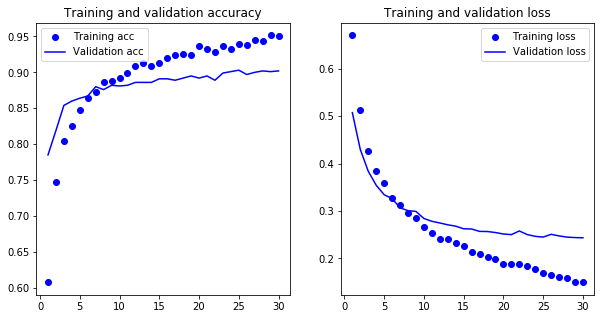

In [40]:
import matplotlib.pyplot as plt

acc=hist.history['acc']
val_acc=hist.history['val_acc']
loss=hist.history['loss']
val_loss=hist.history['val_loss']

epochs=range(1, len(acc)+1)

plt.figure(figsize=(10,5))

plt.subplot(121)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.subplot(122)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Method 2

* Extending the model we have (conv_base) by adding Dense layers on top, and running the whole thing end-to-end on the input data. This allows us to use data augmentation, because every input image is going through the convolutional base every time it is seen by the model. However, for this same reason, this technique is far more expensive than the first one.

In [42]:
def BuildModel2():
  model2=models.Sequential()
  model2.add(conv_base)
  model2.add(layers.Flatten())
  model2.add(layers.Dense(256, activation='relu'))
  model2.add(layers.Dense(1, activation='sigmoid'))
  return model2

mymodel2=BuildModel2()
mymodel2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


In [44]:
print('This is the number of trainable weights '
      'before freezing the conv base:', len(mymodel2.trainable_weights))

This is the number of trainable weights before freezing the conv base: 30


Before we compile and train our model, a very important thing to do is to freeze the convolutional base. "Freezing" a layer or set of layers means preventing their weights from getting updated during training. If we don't do this, then the representations that were previously learned by the convolutional base would get modified during training. Since the Dense layers on top are randomly initialized, very large weight updates would be propagated through the network, effectively destroying the representations previously learned.

In [46]:
conv_base.trainable = False

print('This is the number of trainable weights '
      'before freezing the conv base:', len(mymodel2.trainable_weights))

This is the number of trainable weights before freezing the conv base: 4


With this setup, only the weights from the two `Dense` layers that we added will be trained. That's a total of four weight tensors: two per 
layer (the main weight matrix and the bias vector). Note that in order for these changes to take effect, we must first compile the model. 
If you ever modify weight trainability after compilation, you should then re-compile the model, or these changes would be ignored.

Now we can start training our model, with the same data augmentation configuration that we used in our previous example:

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [50]:
train_datagen = ImageDataGenerator(
      rescale=1./255, rotation_range=40, width_shift_range=0.2, 
      height_shift_range=0.2, shear_range=0.2, zoom_range=0.2,
      horizontal_flip=True, fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir, target_size=(150, 150),
        batch_size=20, class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir, target_size=(150, 150),
        batch_size=20, class_mode='binary')



Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [52]:
mymodel2.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(2e-5),
                 metrics=['acc'])

hist2 = mymodel2.fit(train_generator, steps_per_epoch=100, epochs=5, 
                     validation_data=validation_generator,
                     validation_steps=50, verbose=2)

Train for 100 steps, validate for 50 steps
Epoch 1/5
100/100 - 627s - loss: 0.3699 - acc: 0.8355 - val_loss: 0.2697 - val_acc: 0.8900
Epoch 2/5
100/100 - 629s - loss: 0.3538 - acc: 0.8390 - val_loss: 0.2714 - val_acc: 0.8890
Epoch 3/5
100/100 - 631s - loss: 0.3461 - acc: 0.8470 - val_loss: 0.2660 - val_acc: 0.8970
Epoch 4/5
100/100 - 633s - loss: 0.3245 - acc: 0.8615 - val_loss: 0.2605 - val_acc: 0.8940
Epoch 5/5
100/100 - 627s - loss: 0.3423 - acc: 0.8415 - val_loss: 0.2518 - val_acc: 0.9000


In [0]:
mymodel2.save('cats_and_dogs_small_method2.h5')


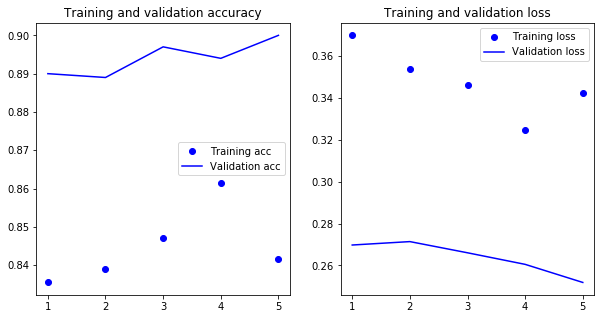

In [54]:
import matplotlib.pyplot as plt

acc=hist2.history['acc']
val_acc=hist2.history['val_acc']
loss=hist2.history['loss']
val_loss=hist2.history['val_loss']

epochs=range(1, len(acc)+1)

plt.figure(figsize=(10,5))

plt.subplot(121)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.subplot(122)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()